# Vanilla Model with Tensorflow and Keras

This model endeavors to reproduce what we did with fast.ai in TensorFlow so that we can use TensorFlow.js

Source: [here](https://www.tensorflow.org/alpha/tutorials/images/transfer_learning)

## Installation
We first need to install TensorFlow 1.12 because TensorFlow 1.13 countains a BatchNormalizationV1 layer that cannot be converted to TensorFlowJS 

In [2]:
!pip install tensorflow==1.12

    100% |████████████████████████████████| 83.1MB 387kB/s 
    100% |████████████████████████████████| 3.1MB 11.3MB/s 
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


## Imports

In [1]:
from __future__ import absolute_import, division, print_function

import os
import re

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
print("TensorFlow version is ", tf.__version__)

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import files
from google.colab import drive

drive.mount('/content/gdrive')

%matplotlib inline

TensorFlow version is  1.12.0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using TensorFlow backend.


## Data preprocessing
We now need to import the data and format it for Keras.

For downloading, we have two options. Either we can download it directly, or import it from Google Drive.

In [0]:
# Option 1:
# data_root = tf.keras.utils.get_file(origin='http://data.vision.ee.ethz.ch/cvl/gfanelli/kinect_head_pose_db.tgz', 
#                                     fname='head_pose', untar=True)
# data_path = '/root/.keras/datasets/hpdb/'

In [0]:
# Option 2
data_path = '/content/gdrive/My Drive/CS 121/TheNoseArcade/Data/hpdb/'

In [6]:
cal = np.genfromtxt(data_path + '01/rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

Now, let us create methods to actually extract the center of the image and try it out

In [0]:
def img2txt_name(f): 
  return data_path + str(f)[:-7] + 'pose.txt'

def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return np.array([c2,c1])

def get_ctr(f):
    try:
      ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
      return convert_biwi(ctr)
    except OSError:
      print(f)
      
  
def get_ips(f):
  img = cv2.imread(data_path + f)
  pt = get_ctr(f)
  return np.array([(pt[0] / img.shape[0]) * 2 - 1, (pt[1] / img.shape[1]) * 2 - 1])

def get_scaled_center(ips, img_shape):
  return (ips[0] + 1) / 2 * img_shape[0], (ips[1] + 1) / 2 * img_shape[1]

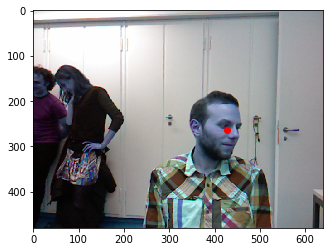

In [10]:
fname = '09/frame_00667_rgb.png'
img = cv2.imread(data_path + fname)
plt.imshow(img)
ips = get_ips(fname)
ctr = get_scaled_center(ips, img.shape)
plt.scatter([ctr[1]], [ctr[0]], c='r')

## Create Training and Validation Arrays
Note that right now, the data from directory 13 is being used for validation because that's what was used in the fast.ai course. This can always be changed later.

In [0]:
valid_dirs = ['13']
train_dirs = [dir for dir in os.listdir(data_path) if len(dir) == 2 and dir not in valid_dirs]

In [0]:
def extract_from_dir(dir, dim):
  # Extract image filenames (we are only using some to reduce RAM usage)
  pattern = re.compile('.*png')
  all_img_fns = [dir + '/' + fn for fn in os.listdir(data_path + dir) if pattern.match(fn)]
  img_fns = np.random.choice(np.array(all_img_fns), size=100, replace=False)
  
  # Now build the x and y arrays
  
  # First declare them, so we won't have to resize anything
  X = np.zeros((len(img_fns), dim, dim, 3)).astype(int)
  y = np.zeros((len(img_fns), 2))
  
  # Now fill in the arrays
  for i in range(len(img_fns)):
    # Read in the image
    img = cv2.imread(data_path + img_fns[i])
    
    # Make it into a square
    size = min(img.shape[0], img.shape[1])
    x_offset = (img.shape[0] - size) // 2
    y_offset = (img.shape[1] - size) // 2
    if (x_offset == 0):
      square = img[:,y_offset:-y_offset,:]
    else:
      square = img[x_offset:-x_offset,:,:]
    
    # Fill the final array
    X[i] = cv2.resize(square, (dim, dim))
    y[i] = get_scaled_center(get_ips(img_fns[i]), X.shape[1:])
    
  return X, y

def extract_data(dirs, dim):
  # Declare the arrays we will use
  X = np.zeros((0, dim, dim, 3)).astype(int)
  y = np.zeros((0, 2))
  
  # For each directory, append on the data
  for dir in dirs:
    x_tmp, y_tmp = extract_from_dir(dir, dim)
    X = np.append(X, x_tmp, axis=0)
    y = np.append(y, y_tmp, axis=0)
    
  return X,y

Now, before we can actually extract the data, we need to set how large the images are going to be, post-resizing

In [0]:
image_size = 160

In [37]:
x_train, y_train = extract_data(train_dirs, image_size)
x_valid, y_valid = extract_data(valid_dirs, image_size)

02/frame_00011_rgb (1).png


TypeError: ignored

(2300, 160, 160, 3)


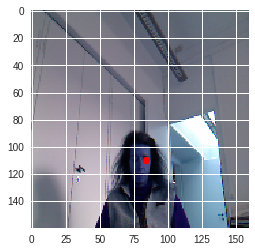

In [12]:
print(x_train.shape)
plt.imshow(x_train[77])
pts = y_train[77]
plt.scatter([pts[1]], [pts[0]], c='r')

## Create Image Data Generator with Image Augmentation
We then need to resize the images and create a data generator, to be used for training / validation

For this section, I used an additional source: [here](https://keras.io/preprocessing/image/\)

In [0]:
batch_size = 32

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(x_train, y_train,
                batch_size=batch_size)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = validation_datagen.flow(x_valid, y_valid,
                batch_size=batch_size)

## Create the base model using a pretrained network
Here we are using ResNet, because that is what was used in the course. It can always be changed later

In [0]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model ResNet
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                            input_shape=IMG_SHAPE, 
                                            weights='imagenet')

## Model Set-Up
We will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It's important to freeze the convolutional based before we compile and train the model. By freezing (or setting layer.trainable = False), we prevent the weights in these layers from being updated during training.

In [0]:
base_model.trainable = False

In [28]:
# Let's take a look at the base model architecture
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

### Add back the top layers
Now let's add a few layers on top of the base model:

In [0]:
model = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(2)
])

### Compile the model
You must compile the model before training it. For this, we will create a new metric, the distance between the ground-truth point and our point

In [0]:
def dist_pred(y_true, y_pred):
    return K.sqrt((y_true[0] - y_pred[0])**2 + (y_true[1] - y_pred[1])**2)

In [0]:
lr = 0.0001 # 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=lr), 
              loss='mean_squared_error', 
              metrics=[dist_pred])

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the Model

In [39]:
epochs = 1
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps)

Epoch 1/1
71/71 [==============================] - 209s 3s/step - loss: 87.8885 - dist_pred: 11.2543 - val_loss: 167.1911 - val_dist_pred: 16.1778


[[93.424576 93.41459 ]]


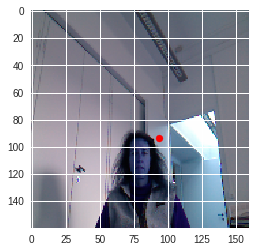

In [40]:
ctr = model.predict(np.expand_dims(x_train[0], axis=0))
plt.imshow(x_train[0])
print(ctr)
plt.scatter([ctr[0][1]], [ctr[0][0]], c='r')

## Saving the Model
First recompile the model so that it no longer uses the accuracy measure, confirm that it is still working, and save it.

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='mean_squared_error', 
              metrics=[])

[[96.459656 96.13201 ]]


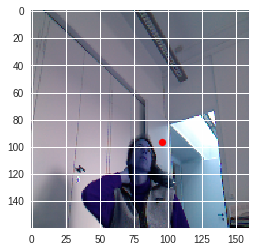

In [45]:
ctr = model.predict(np.expand_dims(x_train[70], axis=0))
plt.imshow(x_train[70])
print(ctr)
plt.scatter([ctr[0][1]], [ctr[0][0]], c='r')

In [0]:
# Save the weights
model.save('test_model.h5')

In [0]:
files.download('test_model.h5')

## Train All Layers

### Unfreeze top 55 layers

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile and train the model

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='mean_squared_error', 
              metrics=[dist_pred])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,865,154
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
fine_epochs = 2

history_fine = model.fit_generator(train_generator, 
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=fine_epochs, 
                                   workers=4,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_steps)

Epoch 1/2
72/72 [==============================] - 249s 3s/step - loss: 23.3431 - dist_pred: 5.7894 - val_loss: 627.1167 - val_dist_pred: 33.3343
Epoch 2/2
72/72 [==============================] - 251s 3s/step - loss: 18.3366 - dist_pred: 5.3055 - val_loss: 363.3828 - val_dist_pred: 24.9774


[[49.036522 52.04717 ]]


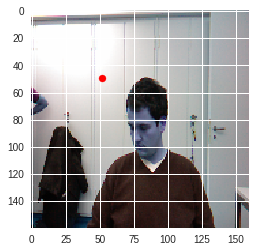

In [0]:
ctr = model.predict(np.expand_dims(x_valid[49], axis=0))
plt.imshow(x_valid[49])
print(ctr)
plt.scatter([ctr[0][1]], [ctr[0][0]], c='r')